# Simple example how to run PlutoSDR on Sionna

The code, excluding the Software-Defined Radio (SDR) functions, is sourced from the Sionna GitHub repository. Adaptations have been made to integrate the SDR radio into the system. Specifically, the PlutoSDR is utilized as a substitute for channel simulation. It takes input from the Sionna modulator and produces a TensorFlow tensor, configured for seamless integration with the Sionna demodulator.

Limitations:

- Batch size must be 1.
- Currently supports SISO 1T1R only, with 2T2R functionality potentially added later.

Important: Transmitting anything requires an appropriate license; failure to have one may result in legal consequences.

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

2024-01-16 14:40:39.143969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 14:40:39.823990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Number of GPUs available : 1
Only GPU number 0 used.


2024-01-16 14:40:40.442255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-16 14:40:40.469185: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-16 14:40:40.469326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sionna
from sionna.mimo import StreamManagement
from tensorflow.keras import Model

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils import BinarySource, ebnodb2no, sim_ber, PlotBER
from sionna.utils.metrics import compute_ber


### Stream Management <a class="anchor" id="Stream-Management"></a>

In [3]:
# Define the number of UT and BS antennas for SISO 1T1R
num_ut = 1
num_bs = 1
num_ut_ant = 1
num_bs_ant = 1

# The number of transmitted streams is equal to the number of UT antennas
num_streams_per_tx = num_ut_ant

# Create an RX-TX association matrix
rx_tx_association = np.array([[1]])

# Instantiate a StreamManagement object
sm = StreamManagement(rx_tx_association, num_streams_per_tx)

### OFDM Resource Grid & Pilot Pattern <a class="anchor" id="OFDM-Resource-Grid-&-Pilot-Pattern"></a>

In [4]:
rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=128,
                  subcarrier_spacing=15e3,
                  num_tx=1,
                  num_streams_per_tx=1,
                  cyclic_prefix_length=7,
                  num_guard_carriers=[15,16],
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2])

2024-01-16 14:40:41.033160: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-16 14:40:41.033359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-16 14:40:41.033463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
num_bits_per_symbol = 8 # 256QAM modulation
coderate = 0.5 # Code rate
n = int(rg.num_data_symbols*num_bits_per_symbol) # Number of coded bits
k = int(n*coderate) # Number of information bits

# The binary source will create batches of information bits
binary_source = BinarySource() 

# The encoder maps information bits to coded bits
encoder = LDPC5GEncoder(k, n)

# The mapper maps blocks of information bits to constellation symbols
mapper = Mapper("qam", num_bits_per_symbol)

# The resource grid mapper maps symbols onto an OFDM resource grid
rg_mapper = ResourceGridMapper(rg)

# The zero forcing precoder precodes the transmit stream towards the intended antennas
zf_precoder = ZFPrecoder(rg, sm, return_effective_channel=True)

# OFDM modulator and demodulator
modulator = OFDMModulator(rg.cyclic_prefix_length)
demodulator = OFDMDemodulator(rg.fft_size, 0, rg.cyclic_prefix_length)

# This function removes nulled subcarriers from any tensor having the shape of a resource grid
remove_nulled_scs = RemoveNulledSubcarriers(rg)

# The LS channel estimator will provide channel estimates and error variances
ls_est = LSChannelEstimator(rg, interpolation_type="nn")

# The LMMSE equalizer will provide soft symbols together with noise variance estimates
lmmse_equ = LMMSEEqualizer(rg, sm)

# The demapper produces LLR for all coded bits
demapper = Demapper("app", "qam", num_bits_per_symbol)

# The decoder provides hard-decisions on the information bits
decoder = LDPC5GDecoder(encoder, hard_out=True)

### import PlutoSDR library for Sionna use

PlutoSDR parameters:
- SDR_TX_IP: IP address of the PlutoSDR
- SDR_TX_FREQ: Transmit frequency in Hz
- SDR_TX_BANDWIDTH: Transmit bandwidth in Hz
- SampleRate: Sample rate in Hz

In [6]:
import SDR_Sionna_1T1R as sdr

SampleRate = rg.fft_size*rg.subcarrier_spacing # sample rate

# Start the radio. Note, radio transmissions are only allowed with appropriate licenses!!!
########################################################################################################################################################
SDR1 = sdr.SDR(SDR_TX_IP="ip:192.168.1.10", SDR_TX_FREQ=435.1e6, RF_BANDWIDTH=SampleRate*1.3, SampleRate = SampleRate)
########################################################################################################################################################


## Eager mode example with SDR 

### Single run in debug mode for SDR debug graphs

sdr.SDR input parameters:
- SAMPLES: symbols output from sionna modulator
- SDR_TX_GAIN: transmitter gain. 0dB is maximum
- add_td_symbols: number of additional symbols to cater for delay spread. Sionna demodulator seems to expect 16 symbols.
- debug: True for pretty(-ish) graphs

sdr.SDR output parameters x_xdr (see below):
- x_sdr[0] : samples
- x_sdr[1] : SINR estimate
- x_sdr[2] : actual TX_Gain setting in SDR
- x_sdr[3] : actual RX_Gain setting in SDR
- x_sdr[4] : Attempts - the algorithm tries to send again with increased power if correlation is not found
- x_sdr[5] : Pearson R - the correlation between transmitted and received signals
- x_sdr[6] : SDR time - how long it took to input the samples, transmit, receive, and output the samples. Typically ~23ms in my test set up, around 1sec if debug=True and graphs are created.

2024-01-16 14:40:43.735537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700


tf.Tensor(146142.45, shape=(), dtype=float32)


/home/riku/projects_ai/sionna-PlutoSDR/SDR_Sionna_1T1R.py:235: RuntimeWarning: divide by zero encountered in log10
  ax.plot(10 * np.log10(np.abs(all_rx_samples) / np.max(np.abs(all_rx_samples))), label='RX_dB')


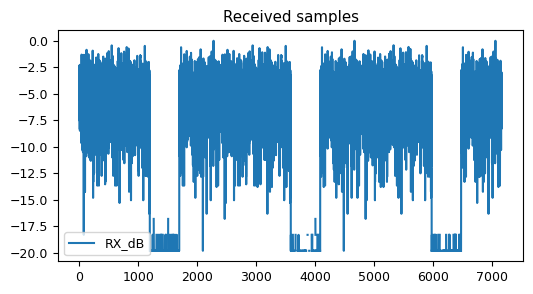

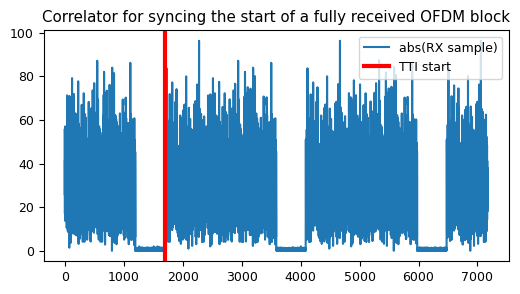

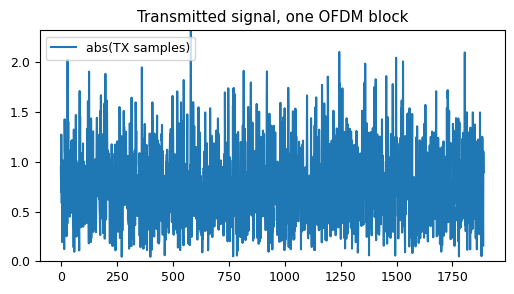

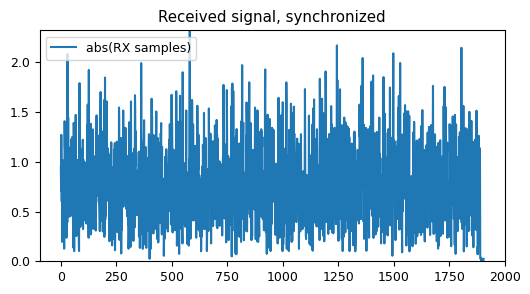

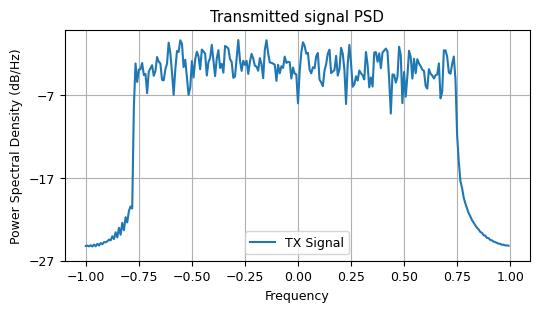

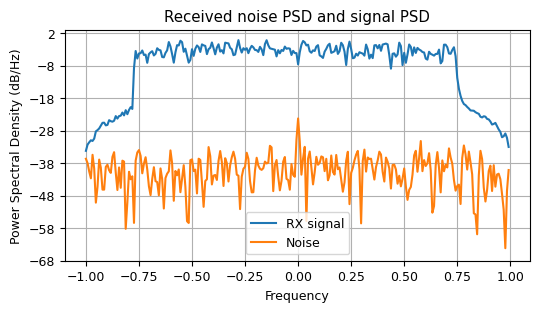

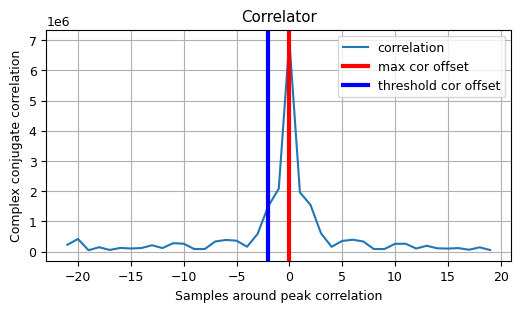

2024-01-16 14:40:45.252541: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x7c9e5e0


BER: 0.000, TX_Gain: -10dB, RX_Gain: 0dB, Attempts: 1, Pearson R: 1.00, SINR 34.1dB, SDR time: 1588ms


In [7]:
batch_size = 1 # We pick a small batch_size as executing this code in Eager mode could consume a lot of memory
b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
c = encoder(b)
x = mapper(c)
x_rg = rg_mapper(x)

# OFDM modulation with cyclic prefix insertion
x_time = modulator(x_rg)

########################################################################################################################################################
x_sdr = SDR1(SAMPLES = x_time, SDR_TX_GAIN=-20, SDR_RX_GAIN = 0, add_td_symbols = 16, debug=True, threshold = 6) # transmit
########################################################################################################################################################

y = demodulator(x_sdr[0]) # received samples in tf Sionna compatible format

no = ebnodb2no((x_sdr[1]), num_bits_per_symbol, coderate, rg) # SINR estimate
h_hat, err_var = ls_est ([y, no]) 

x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
llr = demapper([x_hat, no_eff])
b_hat = decoder(llr)
ber = compute_ber(b, b_hat)

print(f"BER: {ber:1.3f}, TX_Gain: {x_sdr[2]}dB, RX_Gain: {x_sdr[3]}dB, Attempts: {x_sdr[4]}, Pearson R: {x_sdr[5]:1.2f}, SINR {x_sdr[1]:1.1f}dB, SDR time: {x_sdr[6]*1000:1.0f}ms")

```BER: 0.000, TX_Gain: -20dB, RX_Gain: 0dB, Attempts: 1, Pearson R: 0.98, SINR 21.7dB, SDR time: 23ms```

### Multiple runs with various TX power setting

In [8]:
for SDR_TX_GAIN in range(-10,-45,-5):
    
    batch_size = 1 # only batch size 1 is allowed with SDR
    b = binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
    c = encoder(b)
    x = mapper(c)
    x_rg = rg_mapper(x)

    # OFDM modulation with cyclic prefix insertion
    x_time = modulator(x_rg)
    
    ########################################################################################################################################################
    x_sdr = SDR1(SAMPLES = x_time, SDR_TX_GAIN=SDR_TX_GAIN, SDR_RX_GAIN = -10, add_td_symbols = 16, threshold=6, debug=False)
    ########################################################################################################################################################

    # OFDM demodulation and cyclic prefix removal
    y = demodulator(x_sdr[0])

    no = ebnodb2no((x_sdr[1]), num_bits_per_symbol, coderate, rg)
    h_hat, err_var = ls_est ([y, no])

    x_hat, no_eff = lmmse_equ([y, h_hat, err_var, no])
    llr = demapper([x_hat, no_eff])
    b_hat = decoder(llr)
    ber = compute_ber(b, b_hat)
    
    print(f"TX_Gain: {x_sdr[2]}dB, RX_Gain: {x_sdr[3]}dB, SINR {x_sdr[1]:1.1f}dB, coded BER: {ber*100:1.1f}%, Pearson R: {x_sdr[5]:1.2f}, SDR time: {x_sdr[6]*1000:1.0f}ms")


tf.Tensor(149167.8, shape=(), dtype=float32)
TX_Gain: -10dB, RX_Gain: -10dB, SINR 33.1dB, coded BER: 0.0%, Pearson R: 1.00, SDR time: 33ms
tf.Tensor(117246.73, shape=(), dtype=float32)
TX_Gain: -15dB, RX_Gain: -10dB, SINR 26.5dB, coded BER: 0.0%, Pearson R: 1.00, SDR time: 32ms
tf.Tensor(153607.02, shape=(), dtype=float32)
TX_Gain: -20dB, RX_Gain: -10dB, SINR 23.7dB, coded BER: 0.0%, Pearson R: 0.99, SDR time: 31ms
tf.Tensor(134939.56, shape=(), dtype=float32)
TX_Gain: -25dB, RX_Gain: -10dB, SINR 17.8dB, coded BER: 0.0%, Pearson R: 0.98, SDR time: 31ms
tf.Tensor(121437.73, shape=(), dtype=float32)
TX_Gain: -30dB, RX_Gain: -10dB, SINR 12.6dB, coded BER: 24.3%, Pearson R: 0.93, SDR time: 33ms
tf.Tensor(144945.22, shape=(), dtype=float32)
TX_Gain: -35dB, RX_Gain: -10dB, SINR 9.6dB, coded BER: 30.6%, Pearson R: 0.84, SDR time: 33ms
tf.Tensor(134468.94, shape=(), dtype=float32)
TX_Gain: -40dB, RX_Gain: -10dB, SINR 4.9dB, coded BER: 38.4%, Pearson R: 0.62, SDR time: 33ms


256QAM, coding rate 0.5
```
TX_Gain: -10dB, RX_Gain: -10dB, SINR 31.2dB, coded BER: 0.0%, Pearson R: 0.99, SDR time: 26ms
TX_Gain: -15dB, RX_Gain: -10dB, SINR 25.0dB, coded BER: 0.0%, Pearson R: 0.99, SDR time: 27ms
TX_Gain: -20dB, RX_Gain: -10dB, SINR 21.5dB, coded BER: 0.0%, Pearson R: 0.98, SDR time: 25ms
TX_Gain: -25dB, RX_Gain: -10dB, SINR 16.1dB, coded BER: 19.1%, Pearson R: 0.96, SDR time: 24ms
TX_Gain: -30dB, RX_Gain: -10dB, SINR 11.2dB, coded BER: 28.2%, Pearson R: 0.89, SDR time: 24ms
TX_Gain: -35dB, RX_Gain: -10dB, SINR 7.1dB, coded BER: 36.0%, Pearson R: 0.73, SDR time: 24ms
TX_Gain: -40dB, RX_Gain: -10dB, SINR 3.8dB, coded BER: 42.1%, Pearson R: 0.49, SDR time: 24ms

x_sdr[0][0]
<tf.Tensor: shape=(1, 1, 1892), dtype=complex64, numpy=array([[[-0.54005796-0.5170865j ,  
    0.55154365+0.02871427j,
    -0.54005796-0.5170865j , ...,  0.00574285+0.5745151j ,
    -0.54005796+0.02871427j, -0.54005796+0.02871427j]]],
    dtype=complex64)>```

## Keras model example

SDR works as keras layer, however, '@tf.function' needs to be commented out.

In [9]:
class OFDMSystem(Model): # Inherits from Keras Model

    def __init__(self):
        super().__init__() # Must call the Keras model initializer
        
        self.SampleRate = rg.fft_size*rg.subcarrier_spacing # sample rate
        # The binary source will create batches of information bits
        self.binary_source = BinarySource()

        # The encoder maps information bits to coded bits
        self.encoder = LDPC5GEncoder(k, n)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = Mapper("qam", num_bits_per_symbol)

        # The resource grid mapper maps symbols onto an OFDM resource grid
        self.rg_mapper = ResourceGridMapper(rg)

        # The zero forcing precoder precodes the transmit stream towards the intended antennas
        self.zf_precoder = ZFPrecoder(rg, sm, return_effective_channel=True)

        # OFDM modulator and demodulator
        self.modulator = OFDMModulator(rg.cyclic_prefix_length)
        
        ########################################################################################################################################################
        self.SDR1 = sdr.SDR(SDR_TX_IP="ip:192.168.1.10",SDR_TX_FREQ=435e6, RF_BANDWIDTH=self.SampleRate*2, SampleRate = self.SampleRate)
        ########################################################################################################################################################

        self.demodulator = OFDMDemodulator(rg.fft_size, 0, rg.cyclic_prefix_length)

        # This function removes nulled subcarriers from any tensor having the shape of a resource grid
        self.remove_nulled_scs = RemoveNulledSubcarriers(rg)

        # The LS channel estimator will provide channel estimates and error variances
        self.ls_est = LSChannelEstimator(rg, interpolation_type="nn")

        # The LMMSE equalizer will provide soft symbols together with noise variance estimates
        self.lmmse_equ = LMMSEEqualizer(rg, sm)

        # The demapper produces LLR for all coded bits
        self.demapper = Demapper("app", "qam", num_bits_per_symbol)

        # The decoder provides hard-decisions on the information bits
        self.decoder = LDPC5GDecoder(encoder, hard_out=True)

    #@tf.function # Graph execution to speed things up, this how ever will not work
    def __call__(self, batch_size, SDR_TX_GAIN):

        b = self.binary_source([batch_size, 1, rg.num_streams_per_tx, encoder.k])
        c = self.encoder(b)
        x = self.mapper(c)
        x_rg = self.rg_mapper(x)

        # OFDM modulation with cyclic prefix insertion
        x_time = self.modulator(x_rg)
        
        # Pluto_SDR TX & RX instead of channel simulation
        ########################################################################################################################################################
        x_sdr = self.SDR1(SAMPLES = x_time, SDR_TX_GAIN=SDR_TX_GAIN, SDR_RX_GAIN = -10, add_td_symbols = 16, threshold=6, debug=False)
        ########################################################################################################################################################
        
        # OFDM demodulation and cyclic prefix removal
        y = self.demodulator(x_sdr[0])
        SINR_dB = x_sdr[1]
        no = ebnodb2no((SINR_dB), num_bits_per_symbol, coderate, rg)
        h_hat, err_var = self.ls_est ([y, no])

        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])
        llr = self.demapper([x_hat, no_eff])
        
        c_hat = tf.cast(tf.less(0.0, llr), tf.float32) # hard-decided bits before dec.
        ber_uncoded = sionna.utils.metrics.compute_ber(tf.reshape(c, [-1]), tf.reshape(c_hat, [-1]))

        b_hat = self.decoder(llr)
        ber_coded = sionna.utils.metrics.compute_ber(b, b_hat)

        return b, b_hat, x_sdr[1], ber_uncoded.numpy(), ber_coded.numpy()


### Run the OFDM system with SDR radio interface 

The process is iteratively executed $n$ times, each iteration involving the adjustment of the Transmission (TX) power setting. The TX power is systematically decreased from 0dB to -35dB in increments of 2dB. It is observed that the maximum power output, approximately 10dBm, is attained with a TX power setting of 0dB in the PlutoSDR.

In [10]:
model_ls = OFDMSystem()

for SDR_TX_GAIN in range(0,-45,-5):
    out_from_SDR = model_ls(1,SDR_TX_GAIN)

    print(f'SINR={tf.round(out_from_SDR[2],1)}, uncoded BER={round(out_from_SDR[3],2)}, coded BER={round(out_from_SDR[4],2)}')


tf.Tensor(140940.88, shape=(), dtype=float32)
SINR=42.0, uncoded BER=0.06, coded BER=0.0
tf.Tensor(139107.53, shape=(), dtype=float32)
SINR=38.0, uncoded BER=0.05, coded BER=0.0
tf.Tensor(141993.6, shape=(), dtype=float32)
SINR=33.0, uncoded BER=0.04, coded BER=0.0
tf.Tensor(145574.38, shape=(), dtype=float32)
SINR=29.0, uncoded BER=0.04, coded BER=0.0
tf.Tensor(130608.52, shape=(), dtype=float32)
SINR=23.0, uncoded BER=0.08, coded BER=0.0
tf.Tensor(131328.11, shape=(), dtype=float32)
SINR=18.0, uncoded BER=0.14, coded BER=0.17
tf.Tensor(134943.69, shape=(), dtype=float32)
SINR=14.0, uncoded BER=0.21, coded BER=0.23
tf.Tensor(137136.64, shape=(), dtype=float32)
SINR=10.0, uncoded BER=0.3, coded BER=0.31
tf.Tensor(103131.07, shape=(), dtype=float32)
SINR=4.0, uncoded BER=0.39, coded BER=0.41


Test results with 256QAM, coding rate 0.5

```
SINR=40.0, uncoded BER=0.0, coded BER=0.0
SINR=35.0, uncoded BER=0.0, coded BER=0.0
SINR=31.0, uncoded BER=0.0, coded BER=0.0
SINR=25.0, uncoded BER=0.03, coded BER=0.0
SINR=20.0, uncoded BER=0.09, coded BER=0.0
SINR=16.0, uncoded BER=0.17, coded BER=0.19
SINR=11.0, uncoded BER=0.25, coded BER=0.26
SINR=7.0, uncoded BER=0.36, coded BER=0.37
SINR=4.0, uncoded BER=0.4, coded BER=0.4